# KPI Metrics Visualization

We use key performance indicators, or KPIs, to measure the effectiveness of CI testing processes and understand how to improve them. These KPIs are calculated in notebooks and saved as different metrics. You can see a list of the available metrics and the notebooks that calculate them [here](https://github.com/aicoe-aiops/ocp-ci-analysis/tree/master/notebooks/data-sources/TestGrid/metrics).

Through this notebook, we want to provide a way for users to explore and visualize the available metrics. Although we plan on setting up external tools (such as Apache Superset) for visualization, we also want to provide the option to visualize KPIs in a Jupyter notebook native environment since that is where a lot of data science development happens. 

This notebook comprises of these main sections:
1. Fetch and view available data from Ceph bucket
2. Create graphs for all the KPIs available, for a selected dashboard and job
3. Create graphs for the KPIs at a job level, for a selected dashboard
4. Create graphs for all the KPIs at a test level, for a selected dashboard and job

In [1]:
# Import required libraries
import os
from tqdm import tqdm
from collections import defaultdict
from dotenv import load_dotenv, find_dotenv

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

from ipynb.fs.defs.metric_template import CephCommunication

load_dotenv(find_dotenv())
sns.set(rc={"figure.figsize": (15, 5)})

In [2]:
## Specify variables

## CEPH Bucket variables
## Create a .env file on your local with the correct configs
## Follow this example - https://github.com/aicoe-aiops/ocp-ci-analysis/blob/master/.env-example
s3_endpoint_url = os.getenv("S3_ENDPOINT")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")
s3_path = os.getenv("S3_PROJECT_KEY")

# Specify whether or not we are running this as a notebook or part of an automation pipeline.
AUTOMATION = os.getenv("IN_AUTOMATION")

In [3]:
## Connect to Ceph

# ceph connector
cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)

# bucket where the KPI metrics are stored
metrics_bucket = cc.s3_resource.Bucket(s3_bucket)

# get all objects (files) corresponding to all metrics
available_kpi_files = metrics_bucket.objects.filter(Prefix=s3_path)

## Helper functions

In [4]:
def get_kpi_data(
    date, dashboard, job, kpis_s3_bucket=metrics_bucket, kpis_s3_path=s3_path
):
    # get the available parquet filenames
    kpi_files = kpis_s3_bucket.objects.filter(Prefix=kpis_s3_path)

    # read parquet file corresponding to each of the kpis
    all_kpis_df = pd.DataFrame()
    for kf in kpi_files:

        if date in kf.key:
            curr_kpi_df = cc.read_from_ceph(
                kpis_s3_path,
                kf.key.split("/", maxsplit=1)[-1],
            )

            if "grid" in curr_kpi_df.columns:
                curr_kpi_df = curr_kpi_df[
                    (curr_kpi_df["tab"] == dashboard) & (curr_kpi_df["grid"] == job)
                ]
            elif "job" in curr_kpi_df.columns:
                curr_kpi_df = curr_kpi_df[
                    (curr_kpi_df["tab"] == dashboard) & (curr_kpi_df["job"] == job)
                ]
            else:
                print(
                    f'Neither "job" nor "grid" column found in {kf.key}. Maybe this df has a different schema. '
                    f"Appending it as-is, without filtering."
                )

            is_col_allnans = curr_kpi_df.isna().all()
            if curr_kpi_df.empty:
                print(
                    f"No data found in {kf.key} corresponding to dashboard {dashboard} and job {job}. Skipping this df"
                )
            elif is_col_allnans.any():
                print(
                    f"Found columns that were all nans: {is_col_allnans[is_col_allnans].index}. Skipping this df"
                )
            else:
                all_kpis_df = pd.concat(
                    [
                        all_kpis_df,
                        curr_kpi_df,
                    ],
                )

    return all_kpis_df

In [5]:
def plot_grids(tab, test, df, metric_name, x_label, y_label, graph_title):
    """
    Takes as an argument the dashboard tab, test name, metric df, the KPI metric, metric unit and
    the graph title

    Plots the distribution of KPI values over time for the different jobs(grids)
    in a given TestGrid dashboard tab
    """
    for grid in df[df["tab"] == tab]["grid"].unique():
        grid_values = pd.DataFrame()
        grid_values = df[
            (df["tab"] == tab) & (df["grid"] == grid) & (df["test"] == test)
        ]
        sns.lineplot(
            x="timestamp",
            y=metric_name,
            data=grid_values,
            legend="brief",
            label=str(grid),
        )
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(graph_title)
        plt.show()

In [6]:
def plot_metrics_tab_grid(tab, grid, df, metric_name, x_label, y_label, graph_title):
    """
    Takes as an argument the TestGrid dashboard tab, grid(job), metric data frame, the KPI metric name,
    and the title of the graph

    Plots the KPI values over time for the particular grid(job) in a given TestGrid dashboard tab
    Plots change in KPI metrics over time
    """
    df = df[(df["tab"] == tab) & (df["grid"] == grid)]
    print(df.shape)
    sns.set(rc={"figure.figsize": (15, 5)})
    sns.lineplot(x="timestamp", y=metric_name, data=df)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(graph_title)
    plt.show()

In [7]:
def plot_tests(tab, grid, df, metric_name, x_label, y_label, graph_title):
    """
    Takes as an argument the dashboard tab, grid(job), metric data frame, KPI metric, metric unit and
    the graph title

    Plots the distribution of KPI values over time for the different tests in a job(grid) of a given
    TestGrid dashboard tab
    """
    for test in df[(df["tab"] == tab) & (df["grid"] == grid)]["test"].unique():
        grid_values = pd.DataFrame()
        grid_values = df[
            (df["tab"] == tab) & (df["grid"] == grid) & (df["test"] == test)
        ]
        sns.lineplot(
            x="timestamp",
            y=metric_name,
            data=grid_values,
            legend="brief",
            label=str(test),
        )
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(graph_title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

In [8]:
# Function to plot percentages on the bar graph
def with_hue(plot, feature, number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = "{:.1f}%".format(
                100 * a[(j * number_of_categories + i)] / total
            )
            x = (
                patch[(j * number_of_categories + i)].get_x()
                + patch[(j * number_of_categories + i)].get_width() / 2
                - 0.15
            )
            y = (
                patch[(j * number_of_categories + i)].get_y()
                + patch[(j * number_of_categories + i)].get_height()
            )
            ax.annotate(percentage, (x, y), size=12)
    plt.show()

## Get KPI Data
We will connect to Ceph and identify the available KPI parquet files.

In [12]:
# extract the names of unique KPI metric files, and the KPIs available in them
kpis_in_kpifile = defaultdict(list)
dates_available_for_kpifile = defaultdict(list)

# list of available dashboards and jobs for which KPIs are available
available_dashboards = set()
available_jobs_per_dashboard = defaultdict(set)

for obj in tqdm(available_kpi_files):

    # NOTE: this file is an inconsistency that resulted from previous experimentation phases
    # it should ideally be removed from the bucket at some point
    if obj.key == "metrics/flake.parquet":
        continue

    # split key into prefix "directory", metric name, and filename
    dir_name, metric_obj_name, file_name = obj.key.split("/")

    # update dictionary if key doesnt exist
    if metric_obj_name not in kpis_in_kpifile:
        # read a sample file to see what kpis are contained in this file
        sample_file = cc.read_from_ceph(f"{dir_name}/{metric_obj_name}", file_name)

        if "tab" in sample_file.columns:
            # what dashboards do we have data for
            curr_df_dashboards = sample_file["tab"].unique()
            available_dashboards.update(curr_df_dashboards)

            # get a mapping of dashboard:jobs from the current file
            # then update the global dict to make sure we're not missing anything
            if "job" in sample_file.columns:
                curr_df_jobs_per_dashboard = (
                    sample_file[["tab", "job"]]
                    .drop_duplicates()
                    .groupby("tab")
                    .apply(lambda x: set(x.job.tolist()))
                    .to_dict()
                )
                for k, v in curr_df_jobs_per_dashboard.items():
                    available_jobs_per_dashboard[k].update(v)
            elif "grid" in sample_file.columns:
                curr_df_jobs_per_dashboard = (
                    sample_file[["tab", "grid"]]
                    .drop_duplicates()
                    .groupby("tab")
                    .apply(lambda x: set(x.grid.tolist()))
                    .to_dict()
                )
                for k, v in curr_df_jobs_per_dashboard.items():
                    available_jobs_per_dashboard[k].update(v)
            else:
                print(
                    f"Neither grid nor job column found in {file_name}. Cannot extract job info"
                )
        else:
            print(f"tab column not found in {file_name}. Cannot extract dashboard info")

        # get these kpis names
        kpis = sample_file.columns.drop(
            ["timestamp", "tab", "job", "grid", "test"], errors="ignore"
        ).tolist()

        # update mapping of "filename": "kpi"
        kpis_in_kpifile[metric_obj_name] = kpis

    # update mapping of "metric name": "dates for which data is available"
    date = file_name.split("-", maxsplit=1)[-1].split(".", maxsplit=1)[0]
    dates_available_for_kpifile[metric_obj_name].append(date)

1it [00:00,  7.39it/s]

tab column not found in avg_correlation-2021-4-14.parquet. Cannot extract dashboard info


30it [00:01, 22.85it/s]

tab column not found in correlation-2021-4-14.parquet. Cannot extract dashboard info


97it [00:42,  2.29it/s]


**NOTE** The following kpi file / metric / date selection process is a bit restricted right now since ipywidgets are currently unavailable, but should be more interactive once that issue is resolved.

In [14]:
print("Available dashboards to choose from:", end="\n\n")
for d in available_dashboards:
    print(d)

Available dashboards to choose from:

"redhat-openshift-okd-release-4.7-blocking"
"redhat-openshift-ocp-release-4.2-informing"
"redhat-openshift-informing"
"redhat-openshift-ocp-release-4.1-informing"
"redhat-openshift-ocp-release-4.5-broken"
"redhat-openshift-ocp-release-4.7-broken"
"redhat-openshift-ocp-release-4.7-informing"
"redhat-openshift-okd-release-4.6-blocking"
"redhat-openshift-ocp-release-4.5-blocking"
"redhat-openshift-ocp-release-4.3-informing"
"redhat-openshift-ocp-release-4.6-broken"
"redhat-openshift-ocp-release-4.8-blocking"
"redhat-openshift-okd-release-4.5-blocking"
"redhat-openshift-ocp-release-4.6-blocking"
"redhat-openshift-ocp-release-4.8-informing"
"redhat-openshift-ocp-release-4.7-blocking"
"redhat-openshift-ocp-release-4.4-broken"
"redhat-openshift-ocp-release-4.6-informing"
"redhat-openshift-ocp-release-4.3-blocking"
"redhat-openshift-ocp-release-4.9-informing"
"redhat-single-node"
"redhat-openshift-okd-release-4.5-informing"
"redhat-openshift-okd-release-4.

In [15]:
# Select the TestGrid dashboard for which you want to visualize the KPIs
selected_dashboard = '"redhat-assisted-installer"'

In [16]:
print(f"Available jobs under dashboard {selected_dashboard}:", end="\n\n")
for j in available_jobs_per_dashboard[selected_dashboard]:
    print(j)

Available jobs under dashboard "redhat-assisted-installer":

periodic-ci-openshift-release-master-nightly-4.6-e2e-metal-assisted
periodic-ci-openshift-release-master-nightly-4.7-e2e-metal-assisted-onprem
periodic-ci-openshift-release-master-nightly-4.8-e2e-metal-single-node-live-iso
periodic-ci-openshift-release-master-nightly-4.8-e2e-metal-assisted
periodic-ci-openshift-release-master-nightly-4.8-e2e-metal-assisted-ipv6
periodic-ci-openshift-release-master-nightly-4.7-e2e-metal-assisted


In [14]:
# Select a job/grid from the dashboard
selected_job = "periodic-ci-openshift-release-master-nightly-4.6-e2e-metal-assisted"

In [15]:
# Dates available to fetch the KPI data from
dates_available_for_kpifile

defaultdict(list,
            {'avg_correlation': ['2021-4-14',
              '2021-4-16',
              '2021-4-19',
              '2021-4-29',
              '2021-5-13',
              '2021-5-14',
              '2021-5-16',
              '2021-5-18',
              '2021-5-3',
              '2021-5-5'],
             'blocked_timed_out': ['2021-4-14',
              '2021-4-16',
              '2021-4-19',
              '2021-4-27',
              '2021-5-13',
              '2021-5-14',
              '2021-5-16',
              '2021-5-18',
              '2021-5-3',
              '2021-5-5'],
             'build_pass_failure': ['2021-4-14',
              '2021-4-16',
              '2021-4-19',
              '2021-5-13',
              '2021-5-14',
              '2021-5-16',
              '2021-5-18',
              '2021-5-3',
              '2021-5-5'],
             'correlation': ['2021-4-14',
              '2021-4-16',
              '2021-4-19',
              '2021-4-29',
              '20

In [16]:
selected_date = "2021-5-18"

### Get all KPIs for the selected dashboard, job pair
We will now fetch the available KPIs for the selected dashboard and job for a given date

**NOTE** Some kpi files have no data for the given dashboard/job. e.g. for "redhat-openshift-ocp-release-4.2-informing", "periodic-ci-openshift-release-master-ci-4.2-e2e-gcp", blocked_time_out and test_pass_failure has no data (keys dont exist) and pct_fixed has all nan values.

In [17]:
df = get_kpi_data(
    date=selected_date,
    dashboard=selected_dashboard,
    job=selected_job,
)

Neither "job" nor "grid" column found in metrics/avg_correlation/avg_correlation-2021-5-18.parquet. Maybe this df has a different schema. Appending it as-is, without filtering.
Neither "job" nor "grid" column found in metrics/correlation/correlation-2021-5-18.parquet. Maybe this df has a different schema. Appending it as-is, without filtering.


In [18]:
df = df.reset_index(drop=True)
df.head()

,timestamp,average_number_of_correlated_failures,tab,grid,test,test_blocked,test_timed_out,test_duration,build_failure,build_passing,...,correlated_tests,flake,pct_fixed,consec_fail_rate,mean_fail_len,mean_time_to_fix,pass_to_fail_rate,fail_to_pass_rate,failure,passing
0,2021-05-18 15:38:53.241300,6131.752286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-05-17 00:01:09.000000,NaN,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,False,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-05-15 13:18:27.000000,NaN,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,False,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-05-15 10:56:25.000000,NaN,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,False,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-05-15 02:35:35.000000,NaN,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,False,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## KPIs for the selected dashboard, job
Let us know try to visualize each of the KPIs for the selected dashboard, job

### Percent of passing and failing tests
The `test_pass_failures` [notebook](./test_pass_failures.ipynb) calculates the KPIs: "Number of Passing Tests", "Number of Failing Tests", "Percent of Failing Tests" and "Percent of Passing Tests". These metric can help track and measure the effectiveness and success of the CI testing process.

In [19]:
# Dropping all the rows for which we have the `passing` and `failure` columns as NaN values
tpf_df = df.dropna(subset=["passing", "failure"]).reset_index(drop=True)
tpf_df.head()

,timestamp,average_number_of_correlated_failures,tab,grid,test,test_blocked,test_timed_out,test_duration,build_failure,build_passing,...,correlated_tests,flake,pct_fixed,consec_fail_rate,mean_fail_len,mean_time_to_fix,pass_to_fail_rate,fail_to_pass_rate,failure,passing
0,2021-05-17 00:01:09,NaN,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,NaN,NaN,111.816667,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
1,2021-05-15 13:18:27,NaN,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,NaN,NaN,92.966667,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
2,2021-05-15 10:56:25,NaN,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,NaN,NaN,111.916667,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
3,2021-05-15 02:35:35,NaN,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,NaN,NaN,97.883333,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
4,2021-05-14 18:01:21,NaN,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,NaN,NaN,109.166667,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True


There are 5334 total tests out of which we have True/False values for the `passing` and `failure` columns only for 1743 tests, the remaining are all NaN values. We will visualize the metrics only for these 1743 tests.

#### Number of Test Passes

In [20]:
# Lets see how many tests successfully passed
tpf_df.passing.value_counts()

True     1180
False      65
Name: passing, dtype: int64

In [21]:
test_passes = list(tpf_df.passing.value_counts())
test_passes

[1180, 65]

#### Number of Test Failures

In [22]:
# Lets see how many tests failed
tpf_df.failure.value_counts()

False    1237
True        8
Name: failure, dtype: int64

In [23]:
test_failures = list(tpf_df.failure.value_counts())
test_failures

[1237, 8]

#### Test Pass and Test Failure Percentage

In [24]:
# Let's calculate the test pass/failure percentage
test_passing_percentage = (test_passes[0] / sum(test_passes)) * 100
print("Test Pass percentage:", (test_passing_percentage), "%")
test_failure_percentage = (test_failures[1] / sum(test_failures)) * 100
print("Test Failure percentage:", (test_failure_percentage), "%")

Test Pass percentage: 94.77911646586345 %
Test Failure percentage: 0.642570281124498 %


Now, lets plot a bar plot for the same

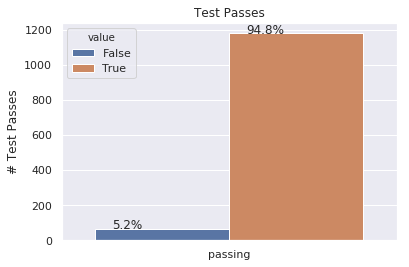

In [25]:
tpf_df_1 = tpf_df[["passing"]]
ax = sns.countplot(x="variable", hue="value", data=pd.melt(tpf_df_1))
plt.xlabel("")
plt.ylabel("# Test Passes")
plt.title("Test Passes")
with_hue(ax, pd.melt(tpf_df_1).variable, 1, 2)

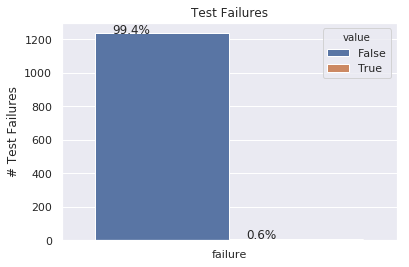

In [26]:
tpf_df_1 = tpf_df[["failure"]]
ax = sns.countplot(x="variable", hue="value", data=pd.melt(tpf_df_1))
plt.xlabel("")
plt.ylabel("# Test Failures")
plt.title("Test Failures")
with_hue(ax, pd.melt(tpf_df_1).variable, 1, 2)

From the above graphs, we see that the total number of test passes that were successful was ~1200 and the number of tests that failed was about ~8. It is also important to note that if a test did not pass successfully, it does not neccessarily mean that it "failed", its possible that the test could be attributed to other status values such as those mentioned in https://github.com/aicoe-aiops/ocp-ci-analysis/blob/master/docs/cell_labels_in_testgrid.md.
Now, lets see how the test passes and failures vary over time.

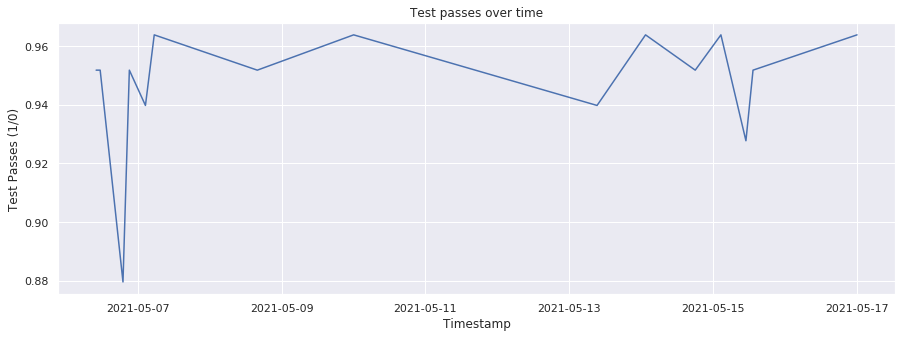

In [27]:
# graph data, test failures over time. 1 indicates "True" and 0 indicates "False"
tpf_df.replace({False: 0, True: 1}, inplace=True)

sns.set(rc={"figure.figsize": (15, 5)})
sns.lineplot(x="timestamp", y="passing", data=tpf_df, ci=None)
plt.xlabel("Timestamp")
plt.ylabel("Test Passes (1/0)")
plt.title("Test passes over time")
plt.show()

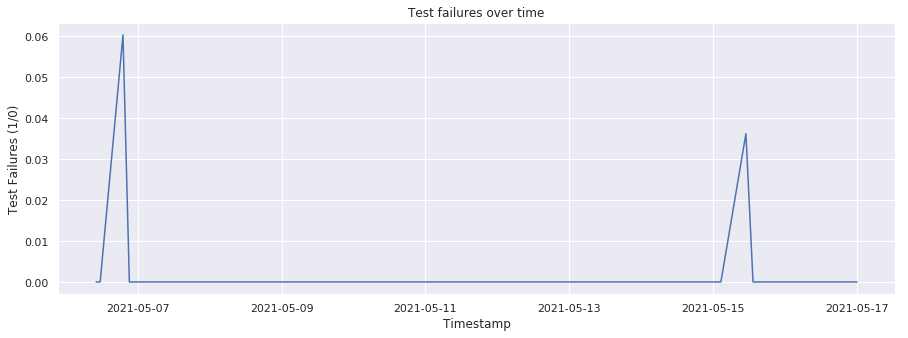

In [28]:
# graph data, test failures over time. 1 indicates "True" and 0 indicates "False"

sns.set(rc={"figure.figsize": (15, 5)})
sns.lineplot(x="timestamp", y="failure", data=tpf_df, ci=None)
plt.xlabel("Timestamp")
plt.ylabel("Test Failures (1/0)")
plt.title("Test failures over time")
plt.show()

### Persistent Failures
The `persistent_failures_analysis` [notebook](./persistent_failures_analysis.ipynb) calculates the KPIs: "Consecutive Failure Rate", "Pass to Fail Rate", "Fail to Pass Rate" and "Mean Time to Fix".

#### Consecutive Failure Rate

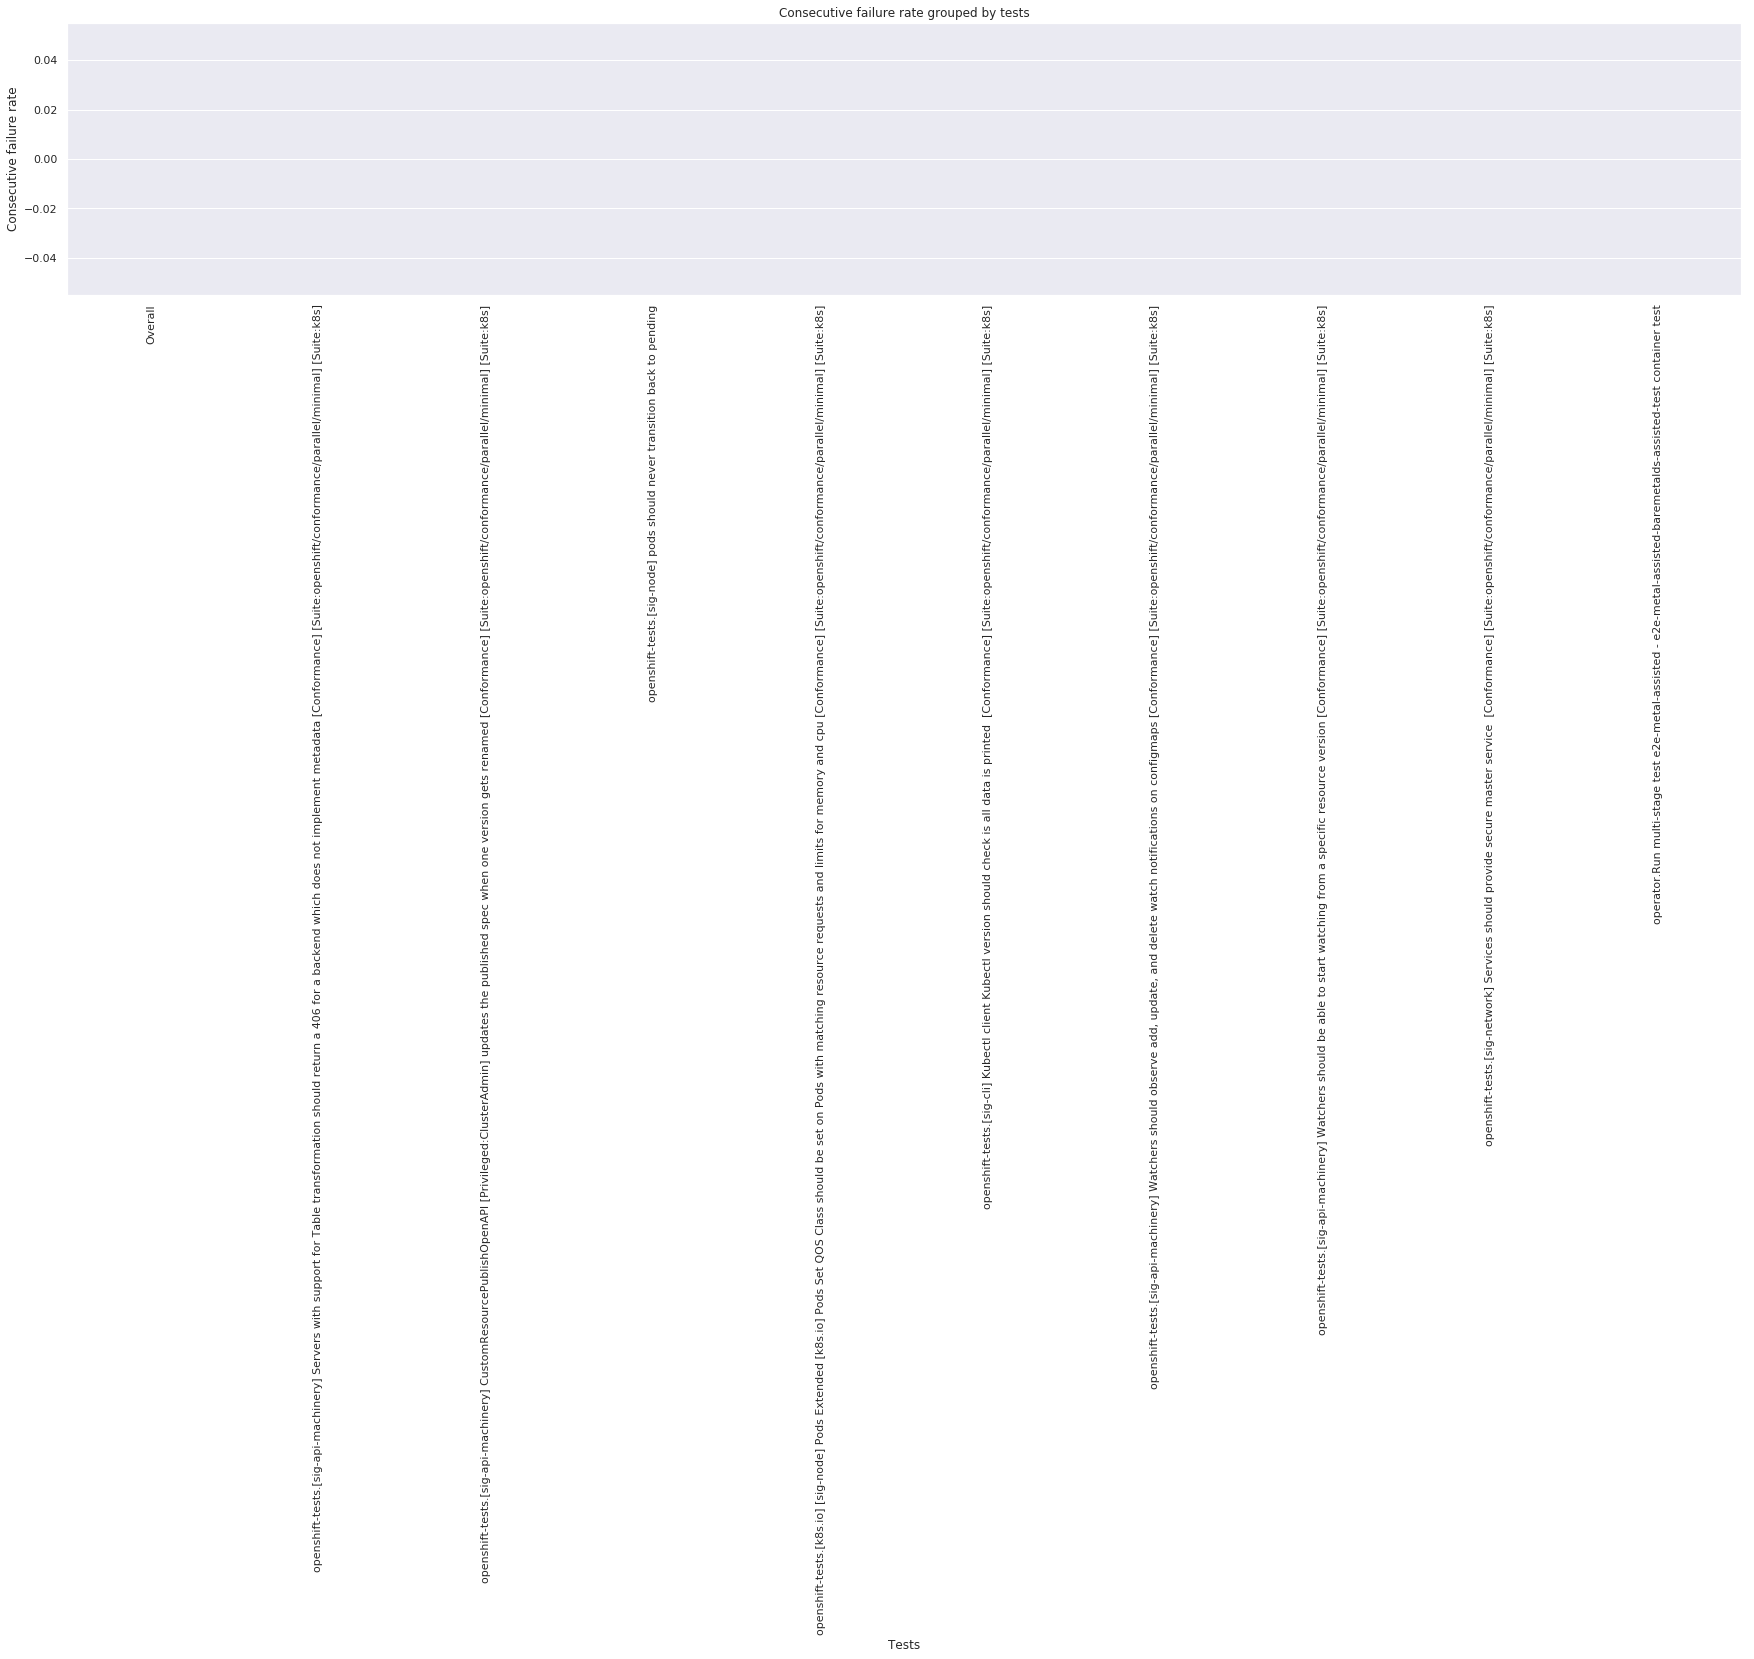

In [29]:
# Lets plot the consecutive failure rate for the tests
sns.set(rc={"figure.figsize": (30, 5)})
sns.barplot(
    x="test",
    y="consec_fail_rate",
    data=df,
    order=df.test.value_counts().iloc[:10].index,
)
plt.xlabel("Tests")
plt.ylabel("Consecutive failure rate")
plt.title("Consecutive failure rate grouped by tests")
plt.xticks(rotation=90)
plt.show()

From the above graph, it seems like on that particular day i.e. "2021-5-18", there were no consecutive failures among the tests.

#### Pass to Fail Rate

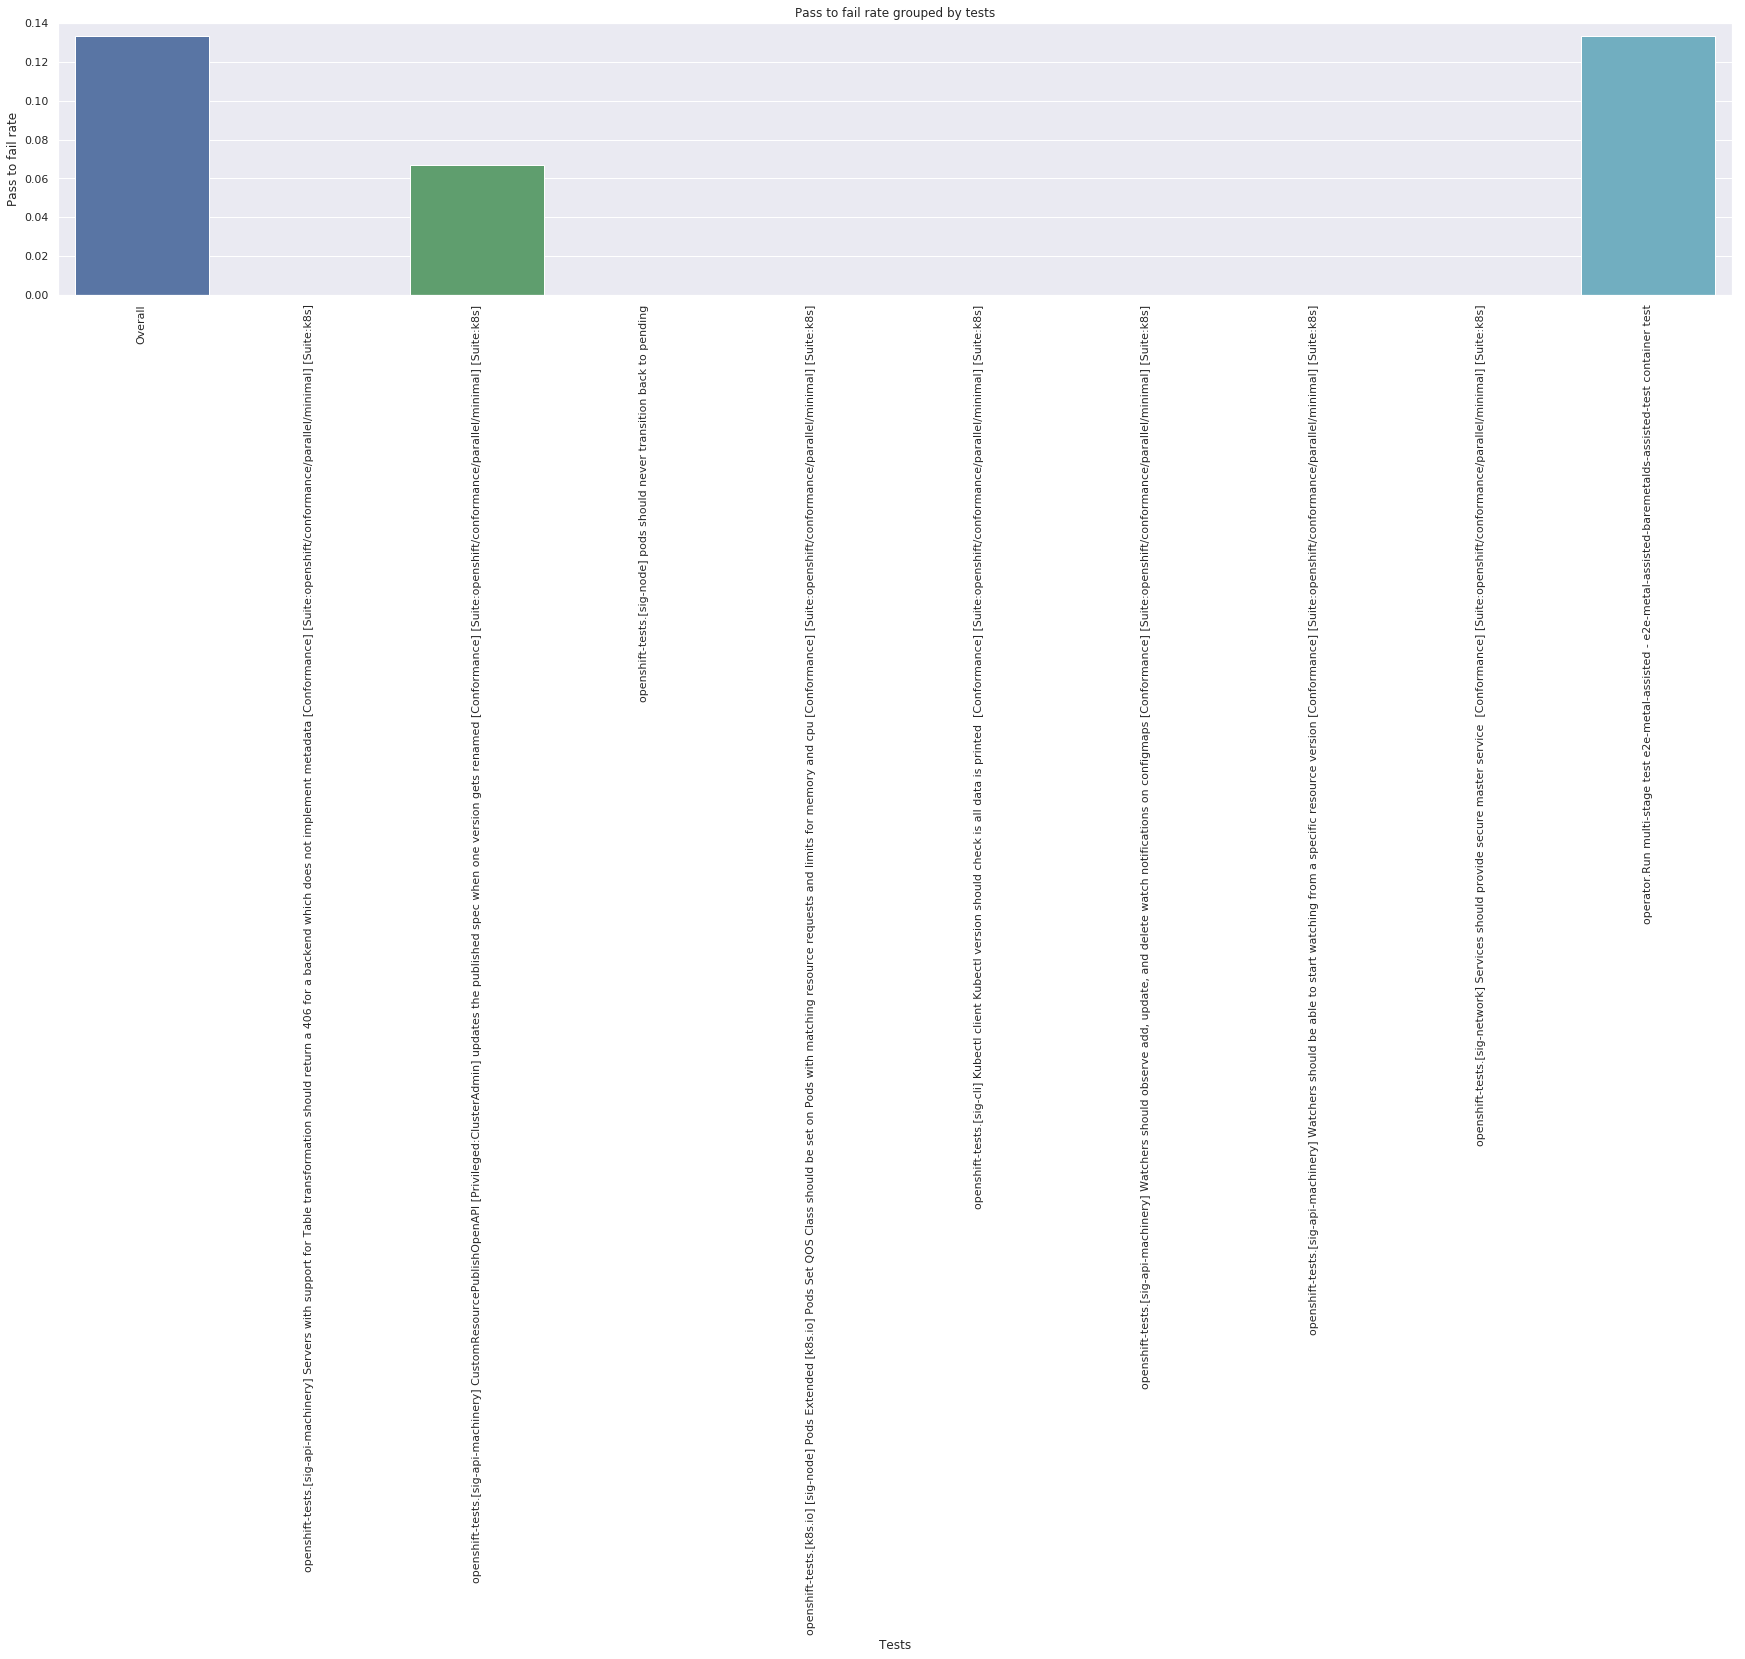

In [30]:
# Lets plot the rate of transition from test pass to fail
sns.set(rc={"figure.figsize": (30, 5)})
sns.barplot(
    x="test",
    y="pass_to_fail_rate",
    data=df,
    order=df.test.value_counts().iloc[:10].index,
)
plt.xlabel("Tests")
plt.ylabel("Pass to fail rate")
plt.title("Pass to fail rate grouped by tests")
plt.xticks(rotation=90)
plt.show()

#### Fail to Pass Rate

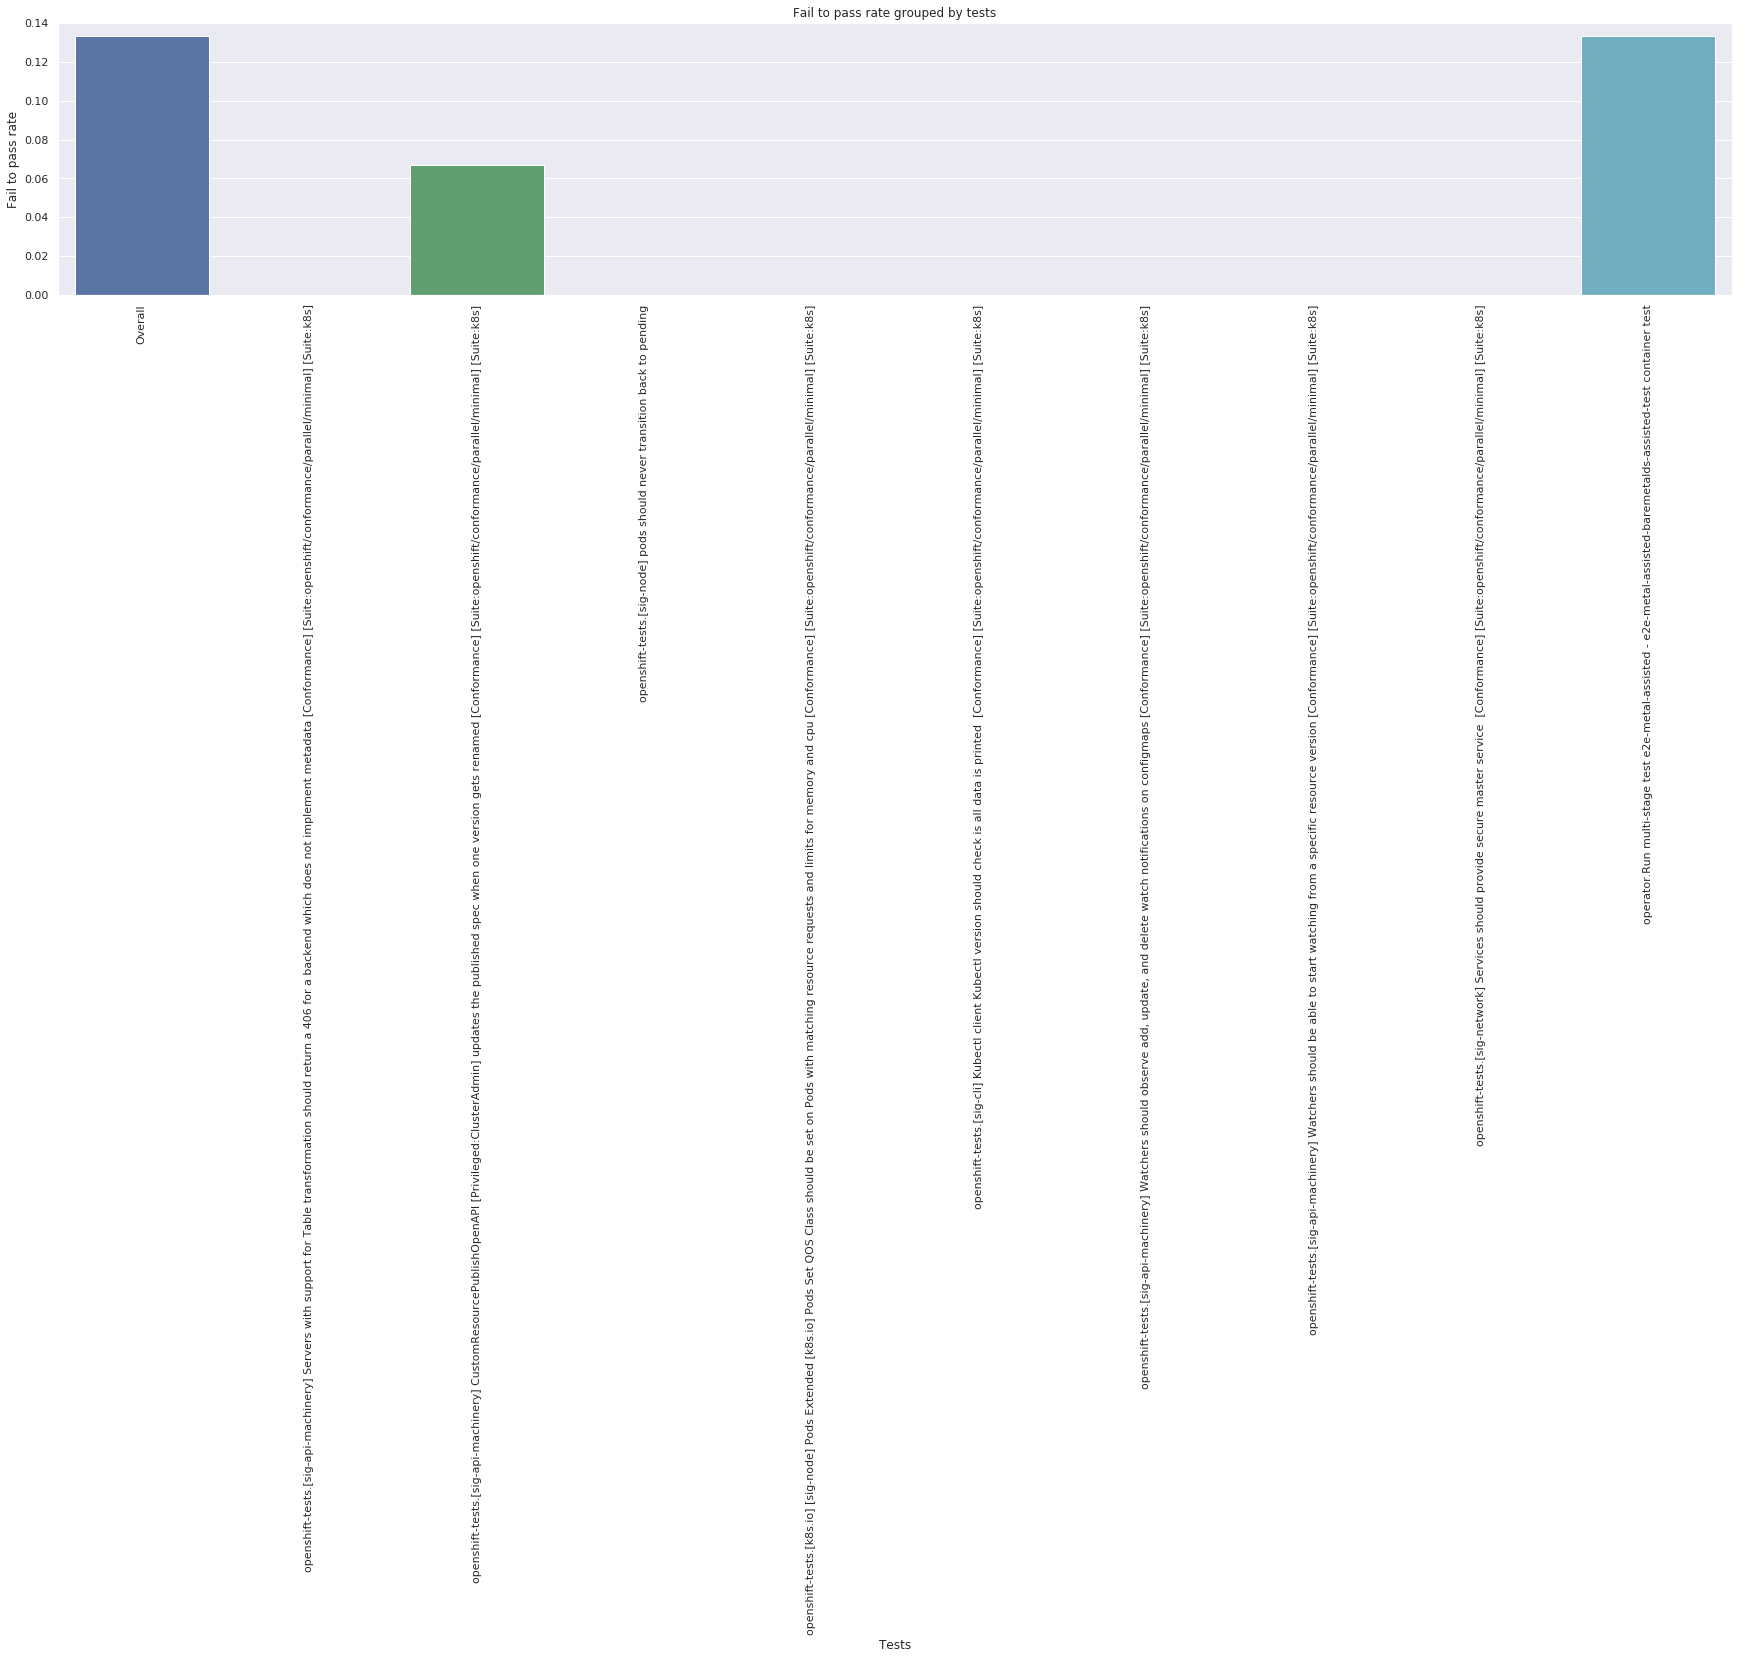

In [31]:
# Lets plot the rate of transition from test fail to pass
sns.set(rc={"figure.figsize": (30, 5)})
sns.barplot(
    x="test",
    y="fail_to_pass_rate",
    data=df,
    order=df.test.value_counts().iloc[:10].index,
)
plt.xlabel("Tests")
plt.ylabel("Fail to pass rate")
plt.title("Fail to pass rate grouped by tests")
plt.xticks(rotation=90)
plt.show()

#### Mean Time to Fix

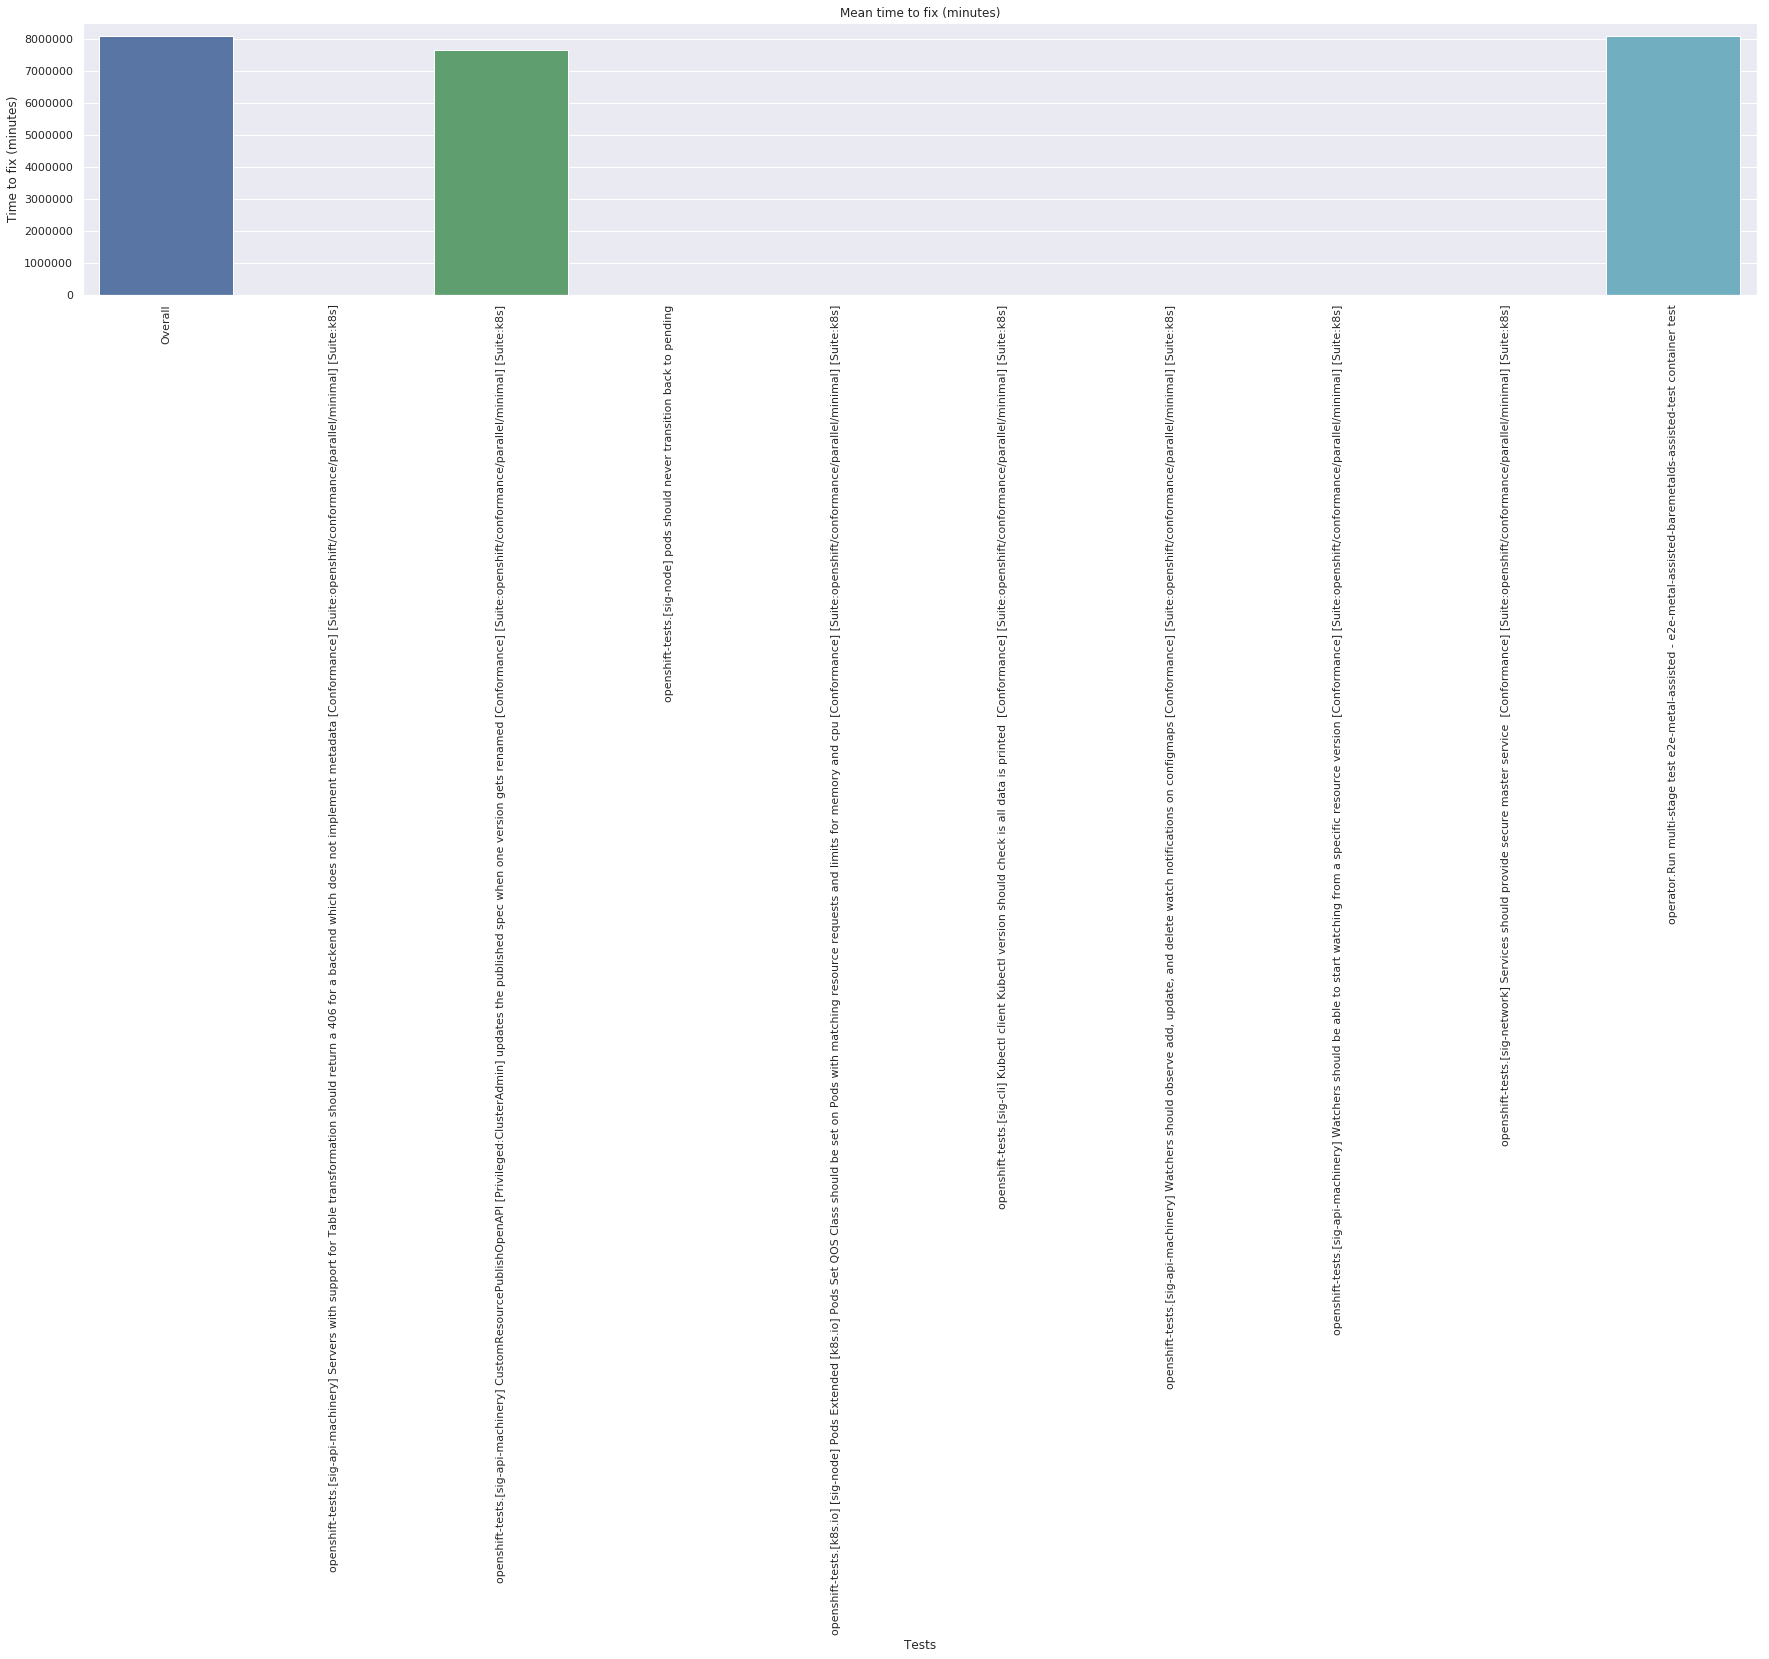

In [32]:
# Lets plot the mean time to fix for each of the tests
sns.set(rc={"figure.figsize": (30, 5)})
sns.barplot(
    x="test",
    y="mean_time_to_fix",
    data=df,
    order=df.test.value_counts().iloc[:10].index,
)
plt.xlabel("Tests")
plt.ylabel("Time to fix (minutes)")
plt.title("Mean time to fix (minutes)")
plt.xticks(rotation=90)
plt.show()

### Time to Test
The `time_to_test` [notebook](./time_to_test.ipynb) calculates the KPI: "Average time to test", which measures the time taken to run builds over time. Lets plot this test duration over time.

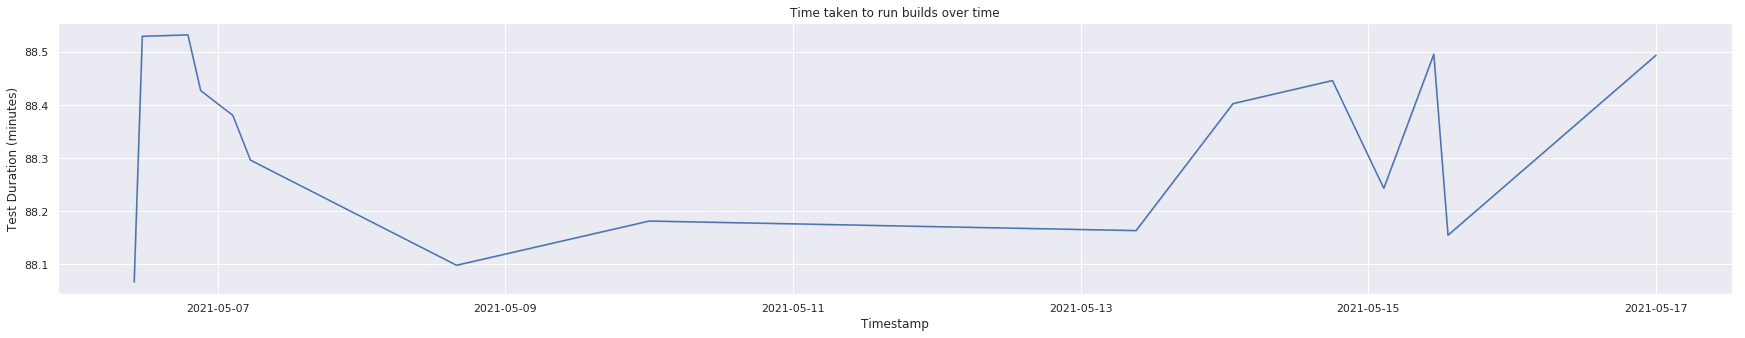

In [33]:
selected_kpis = "test_duration"

sns.lineplot(x="timestamp", y=selected_kpis, data=df, ci=0)
plt.xlabel("Timestamp")
plt.ylabel("Test Duration (minutes)")
plt.title("Time taken to run builds over time")
plt.show()

In the above graph, we see how the time taken to run a build changes over time and we notice when there are spikes or when irregular builds occur.

Now, let's try to see the test duration time for the various tests i.e. understand what the average test duration is and the tests falling within this test duration.

In [34]:
sns.displot(x="test_duration", data=df, hue="test", multiple="stack")
plt.xlabel("Test Duration (minutes)")
plt.ylabel("Number of Tests")
plt.title("Test duration grouped by tests")
plt.show()

AttributeError: module 'seaborn' has no attribute 'displot'

From the above distribution plot, we see that for the dashboard "redhat-openshift-ocp-release-4.2-informing" and job "periodic-ci-openshift-release-master-ci-4.2-e2e-gcp", most of the tests took about ~65 minutes to run the build and there were a few tests like "Symptom Detection.Node process segfaulted" which took a little longer, about ~70-80 minutes to run.

### Percent fixed
The `pct_fixed_each_ts` [notebook](pct_fixed_each_ts.ipynb) calculates the KPI: "Percent of tests fixed", which measures the percent of tests that were failing and are now fixed. 

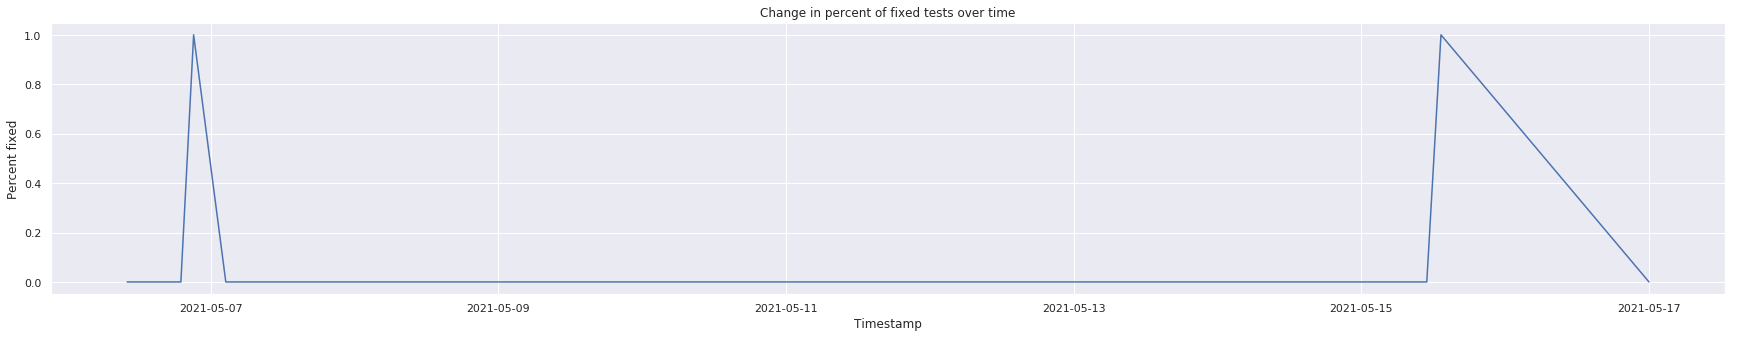

In [35]:
selected_kpis = "pct_fixed"

sns.lineplot(x="timestamp", y=selected_kpis, data=df)
plt.xlabel("Timestamp")
plt.ylabel("Percent fixed")
plt.title("Change in percent of fixed tests over time")
plt.show()

From the above line graph, we see that the percent of fixed tests are quite low. This means that only a small percent of previously failing tests get fixed in each new run, which in turn implies that their CI process is likely not as efficient as it could be.

### Correlated failures
The `correlated_failures` [notebook](./correlated_failures.ipynb) calculates the KPIs: "Correlated test failure sets per test" and "Average size of correlation set", which measures the average number of failures for highly correlated tests i.e, sets of tests that most commonly fail together.

In [36]:
# load data, KPI avg_correlation

selected_filename = "avg_correlation"

metric_df_avg_corr = pd.DataFrame(
    columns=["timestamp", "average_number_of_correlated_failures"]
)

for d in dates_available_for_kpifile[selected_filename]:
    metric_df_avg_corr = metric_df_avg_corr.append(
        cc.read_from_ceph(
            s3_path,
            f"{selected_filename}/{selected_filename}-{d}.parquet",
        )
    )

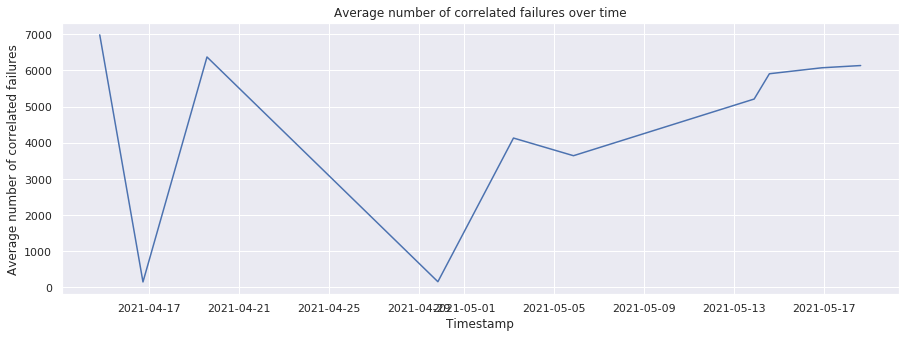

In [37]:
# graph data, KPI average number of correlated failures

metric_name = "average_number_of_correlated_failures"

sns.set(rc={"figure.figsize": (15, 5)})
sns.lineplot(x="timestamp", y=metric_name, data=metric_df_avg_corr)
plt.xlabel("Timestamp")
plt.ylabel("Average number of correlated failures")
plt.title("Average number of correlated failures over time")
plt.show()

From the above line graph, we see that the average number of correlated failures vary quite drastically over time, from being as high as 7000 and having no correlated failures at all.

In [38]:
# read data, KPI correlation
selected_filename = "correlation"
selected_date = "2021-5-18"

metric_df_corr = cc.read_from_ceph(
    s3_path,
    f"{selected_filename}/{selected_filename}-{selected_date}.parquet",
)
metric_df_corr["corr_count"] = metric_df_corr["correlated_tests"].str.len()

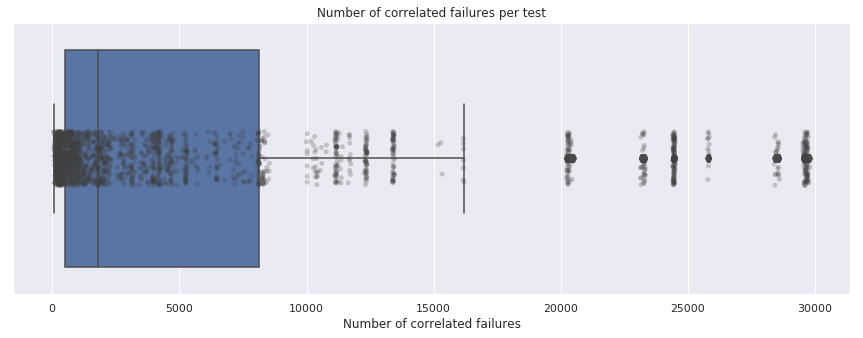

In [39]:
# graph data, KPI correlation
metric_name = "corr_count"

sns.set(rc={"figure.figsize": (15, 5)})
sns.boxplot(x=metric_name, data=metric_df_corr)
sns.stripplot(x=metric_name, data=metric_df_corr, color="0.25", alpha=0.25)
plt.xlabel("Number of correlated failures")
plt.title("Number of correlated failures per test")
plt.show()

From the above box plot, we see that the mean number of correlated failures is about ~6000 and the maximum number of correlated failures observed on that day was about ~20000.

### Blocked, Timed out
The `blocked_timed_out` [notebook](./blocked_timed_out.ipynb) calculates the KPIs: "Number of tests blocked", "Blocked tests percentage", "Number of tests timed out", and "Timed out tests percentage".

In [40]:
# Lets see how many tests blocked out.
df.test_blocked.value_counts()

False    1245
Name: test_blocked, dtype: int64

In [41]:
# Lets see how many tests timed out.
df.test_timed_out.value_counts()

False    1245
Name: test_timed_out, dtype: int64

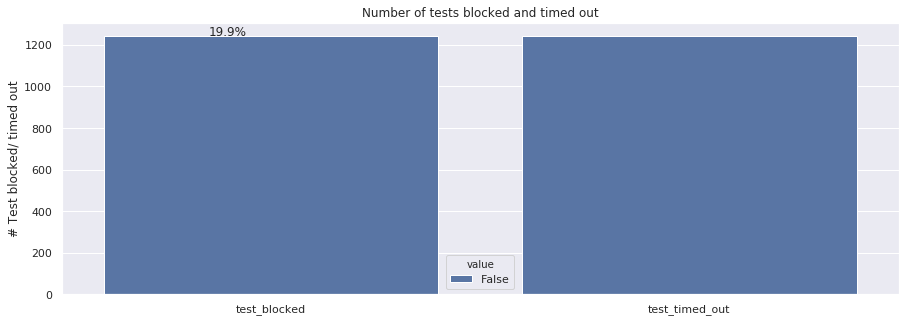

In [42]:
bto_df_1 = df[["test_blocked", "test_timed_out"]]
ax = sns.countplot(x="variable", hue="value", data=pd.melt(bto_df_1))
plt.xlabel("")
plt.ylabel("# Test blocked/ timed out")
plt.title("Number of tests blocked and timed out")
with_hue(ax, pd.melt(bto_df_1).variable, 1, 1)

Here, we can conclude that the test_blocked and test_timed_out values are either unavailable for the data or are "False". 

### Build Pass Failure
The `build_pass_failure` [notebook](./build_pass_failure.ipynb) calculates the KPIs: "Number of builds passed", "Percentage of builds passed", "Number of builds failed", and "Percentage of builds failed".

#### Number of builds passed

In [43]:
# Lets see how many builds passed.
df.build_passing.value_counts()

True     13
False     2
Name: build_passing, dtype: int64

#### Number of builds failed

In [44]:
# Lets see how many builds failed.
df.build_failure.value_counts()

False    13
True      2
Name: build_failure, dtype: int64

Text(0.5, 1.0, 'Number of builds passing/failing')

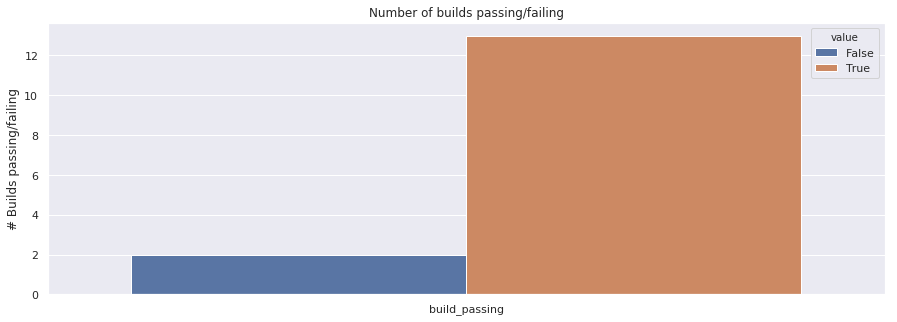

In [45]:
# Lets plot the consecutive failure rate for all tests
bto_df = df[["build_passing"]]
ax = sns.countplot(x="variable", hue="value", data=pd.melt(bto_df))
plt.xlabel("")
plt.ylabel("# Builds passing/failing")
plt.title("Number of builds passing/failing")

For a given dashboard and job the build passing and failure are just the inverse of each other.

### Number of flakes
The `number_of_flakes` [notebook](./number_of_flakes.ipynb) calculates the KPIs: "Flaky tests" and "Flake severity".

In [46]:
# load data, KPI anumber_of_flakes
selected_filename = "number_of_flakes"
selected_date = "2021-5-18"
selected_kpis = [
    "test_duration",
    "flake",
]
# read one of the kpis to plot the selected metrics objects from ceph
metric_df = cc.read_from_ceph(
    s3_path,
    f"{selected_filename}/{selected_filename}-{selected_date}.parquet",
)
metric_df.head()

,timestamp,tab,grid,test,test_duration,flake
0,2021-05-17 00:01:09,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,111.816667,False
1,2021-05-15 13:18:27,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,92.966667,False
2,2021-05-15 10:56:25,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,111.916667,False
3,2021-05-15 02:35:35,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,97.883333,False
4,2021-05-14 18:01:21,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,109.166667,False


In [47]:
metric_df[["test", "flake"]].describe()

,test,flake
count,42200517,42200517
unique,13897,2
top,Overall,False
freq,55544,41971275


#### Flake Severity

In [48]:
flake_severity = metric_df.groupby("test").flake.mean().reset_index()
flake_severity.rename(columns={"flake": "flake_severity"}, inplace=True)

In [49]:
flake_severity.flake_severity.value_counts()

0.000000    12520
0.000037       29
0.000037       26
0.000039       23
0.000037       21
            ...  
0.000103        1
0.154905        1
0.155513        1
0.001736        1
0.000628        1
Name: flake_severity, Length: 767, dtype: int64

In [50]:
sns.histplot(flake_severity, bins=50)
plt.ylabel("Tests")
plt.xlabel("Flake Severity")
plt.show()

AttributeError: module 'seaborn' has no attribute 'histplot'

From the above graph we can conclude that most of the tests have very low(~0) flake severity. One might look at this graph and assume that almost all of the tests have flake severity as 0. So, to get more clarity we have plotted another graph limiting the count to 50.

In [51]:
sns.histplot(flake_severity, bins=50)
plt.ylabel("Tests")
plt.xlabel("Flake Severity")
plt.ylim((0, 50))
plt.show()

AttributeError: module 'seaborn' has no attribute 'histplot'

From the above graph we can see that there are other values of flake severity for some tests. However, it is a small bunch of tests that show a different set of flake severity.

## Visualize KPIs for the different jobs under a given dashboard

In this section, we'll compare jobs within a dashboard on the basis of the selected KPIs. That is, given a dashboard (e.g. `"redhat-openshift-ocp-release-4.6-informing"`), we will plot the KPI values corresponding to the `Overall` row for each job (e.g. `periodic-ci-openshift-release-master-ci-4.6-e2e-aws`, `periodic-ci-openshift-release-master-ci-4.6-e2e-gcp`, etc.) under that dashboard. This would help us determine if our efforts should be focused on a particular platform or install config for OpenShift.

In [52]:
selected_filename = "number_of_flakes"

In [53]:
print(f'Available dates to choose from for the file "{selected_filename}":', end="\n\n")
for d in dates_available_for_kpifile[selected_filename]:
    print(d)

Available dates to choose from for the file "number_of_flakes":

2021-4-14
2021-4-16
2021-4-19
2021-4-27
2021-4-29
2021-5-13
2021-5-14
2021-5-16
2021-5-18
2021-5-3
2021-5-4
2021-5-5
2021-5-6


In [54]:
selected_date = "2021-5-18"

In [55]:
print(f'Available KPIs to choose from for the file "{selected_filename}":', end="\n\n")
for m in kpis_in_kpifile[selected_filename]:
    print(m)

Available KPIs to choose from for the file "number_of_flakes":

test_duration
flake


In [56]:
selected_kpis = [
    "test_duration",
    "flake",
]

In [57]:
# read one of the kpis to plot the selected metrics objects from ceph
metric_df = cc.read_from_ceph(
    s3_path,
    f"{selected_filename}/{selected_filename}-{selected_date}.parquet",
)
metric_df.head()

,timestamp,tab,grid,test,test_duration,flake
0,2021-05-17 00:01:09,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,111.816667,False
1,2021-05-15 13:18:27,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,92.966667,False
2,2021-05-15 10:56:25,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,111.916667,False
3,2021-05-15 02:35:35,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,97.883333,False
4,2021-05-14 18:01:21,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,109.166667,False


In [58]:
tabs = metric_df["tab"].unique()
print("Available dashboard tabs to choose from:", end="\n\n")
for t in tabs:
    print(t)

Available dashboard tabs to choose from:

"redhat-assisted-installer"
"redhat-openshift-informing"
"redhat-openshift-ocp-release-4.1-blocking"
"redhat-openshift-ocp-release-4.1-informing"
"redhat-openshift-ocp-release-4.2-blocking"
"redhat-openshift-ocp-release-4.2-informing"
"redhat-openshift-ocp-release-4.3-blocking"
"redhat-openshift-ocp-release-4.3-broken"
"redhat-openshift-ocp-release-4.3-informing"
"redhat-openshift-ocp-release-4.4-blocking"
"redhat-openshift-ocp-release-4.4-broken"
"redhat-openshift-ocp-release-4.4-informing"
"redhat-openshift-ocp-release-4.5-blocking"
"redhat-openshift-ocp-release-4.5-broken"
"redhat-openshift-ocp-release-4.5-informing"
"redhat-openshift-ocp-release-4.6-blocking"
"redhat-openshift-ocp-release-4.6-broken"
"redhat-openshift-ocp-release-4.6-informing"
"redhat-openshift-ocp-release-4.7-blocking"
"redhat-openshift-ocp-release-4.7-broken"
"redhat-openshift-ocp-release-4.7-informing"
"redhat-openshift-ocp-release-4.8-blocking"
"redhat-openshift-ocp-re

In [59]:
# Select the dashboard and test
selected_tab = '"redhat-assisted-installer"'
selected_test = "Overall"

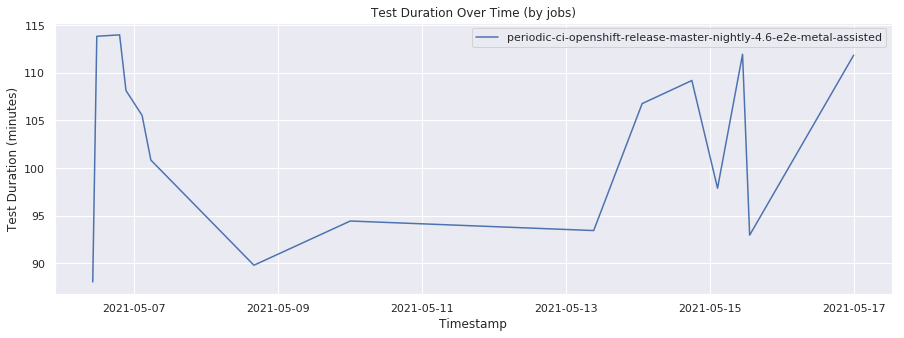

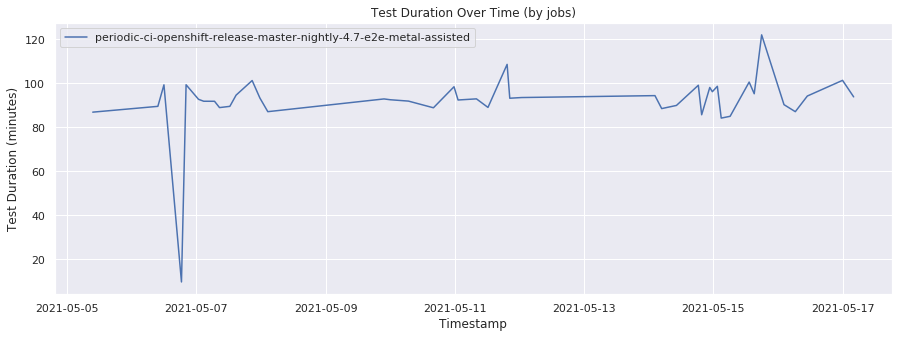

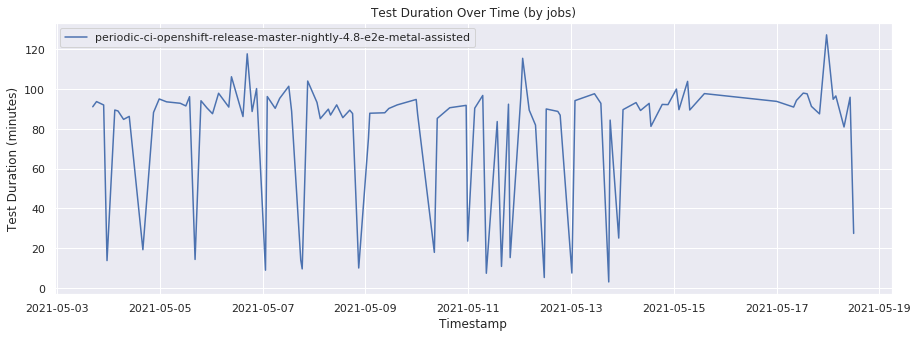

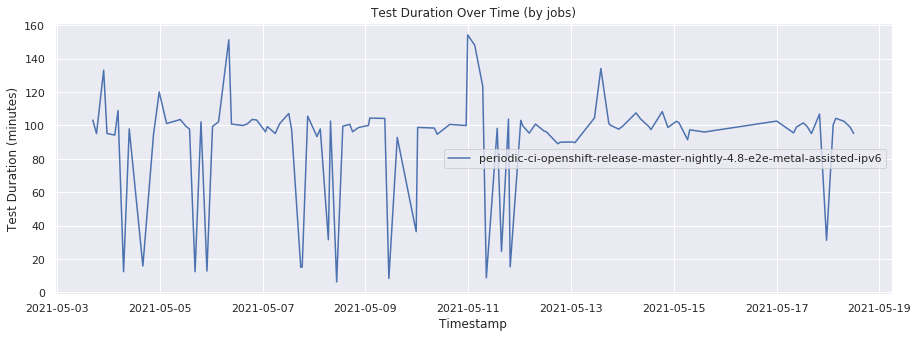

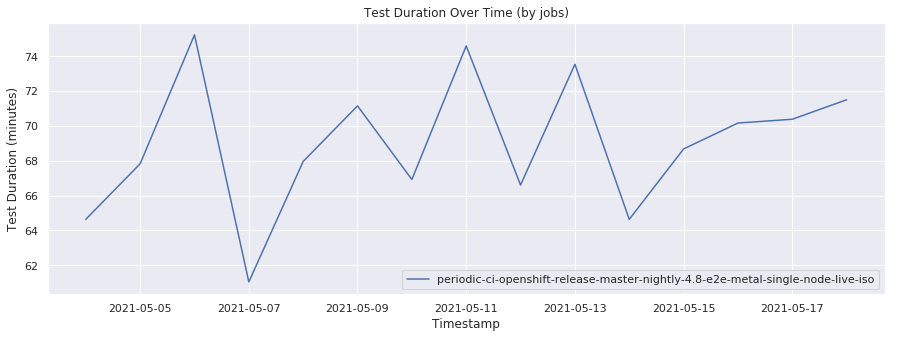

In [60]:
# Here we are plotting the test duration metric over time for the different jobs within a given dashboard tab
plot_grids(
    selected_tab,
    selected_test,
    metric_df,
    selected_kpis[0],
    "Timestamp",
    "Test Duration (minutes)",
    "Test Duration Over Time (by jobs)",
)

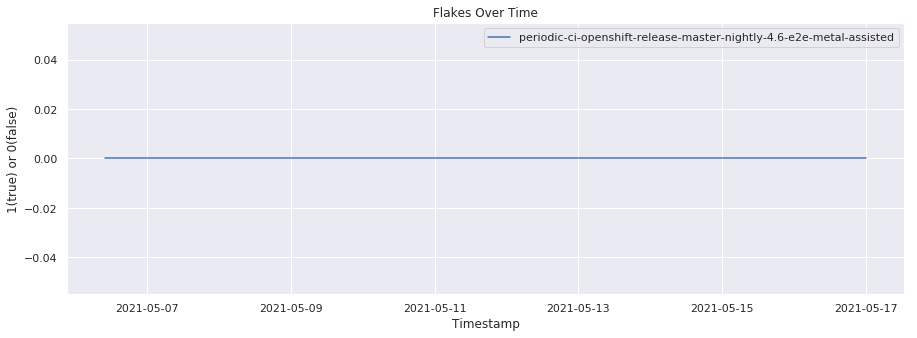

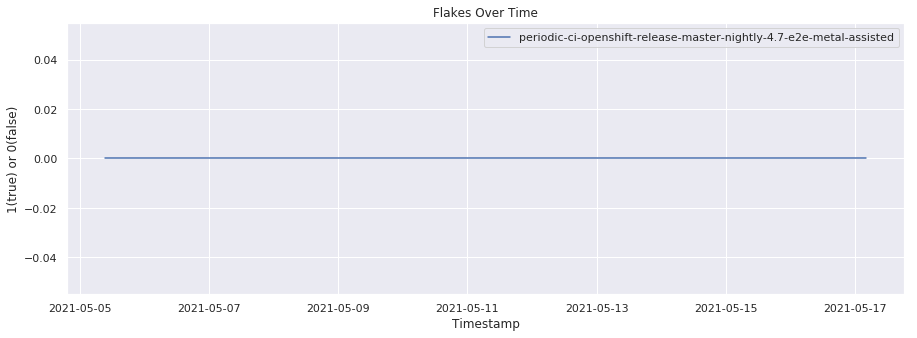

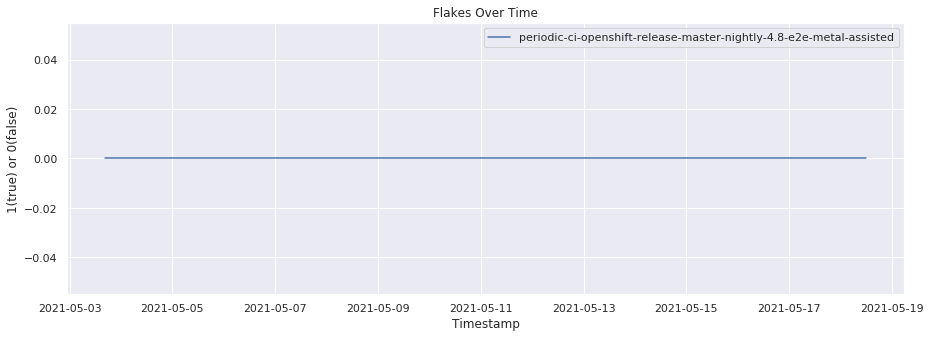

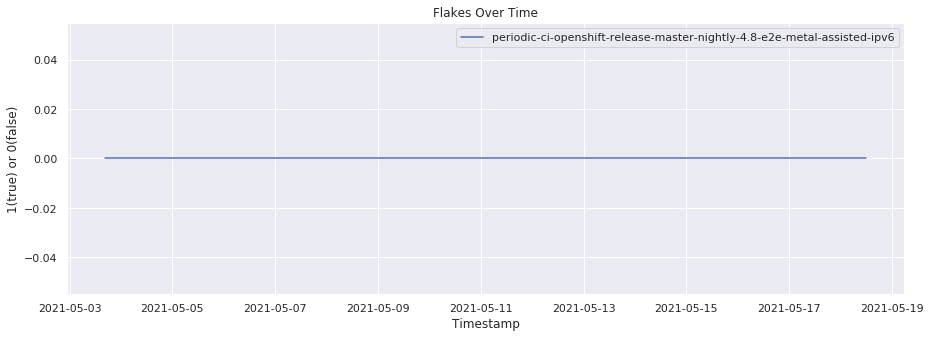

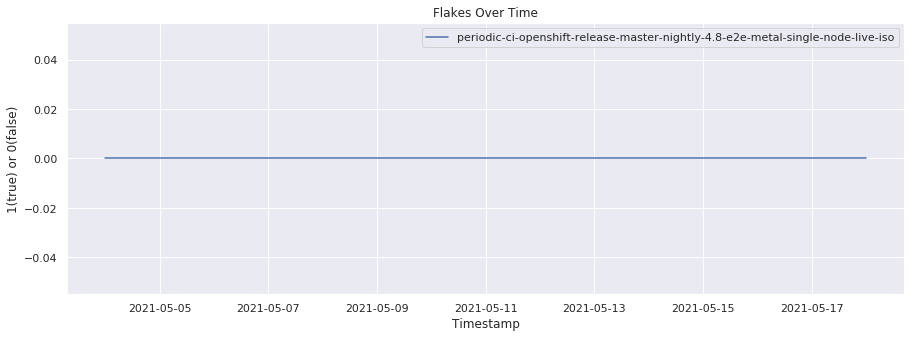

In [61]:
# Here we are plotting the flakes over time for the different jobs within a given dashboard tab
plot_grids(
    selected_tab,
    selected_test,
    metric_df,
    selected_kpis[1],
    "Timestamp",
    "1(true) or 0(false)",
    "Flakes Over Time",
)

## Visualize the KPIs for different tests under a given job

In this section, we'll compare the various tests that are run in a job, on the basis of the selected KPIs. That is, given a job (e.g. `periodic-ci-openshift-release-master-ci-4.6-e2e-gcp`), we will plot the KPI values corresponding to each test (e.g. `operator conditions cluster-autoscaler`, `operator conditions cloud-credential`, etc.) under that job. This would help us determine if our efforts should be focused on a particular set of components in OpenShift.

In [62]:
# For a given dashboard, identify all the jobs (grids)
selected_tab = '"redhat-openshift-ocp-release-4.1-informing"'

grids = metric_df[metric_df["tab"] == selected_tab]["grid"].unique()
print("Available grids to choose from:", end="\n\n")
for g in grids:
    print(g)

Available grids to choose from:

release-openshift-origin-installer-e2e-aws-upgrade-4.1-stable-to-4.1-nightly
release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.1


In [63]:
# Select the job(grid)
selected_grid = "release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.1"

In [64]:
df = metric_df.copy()
df = df[(df["tab"] == selected_tab) & (df["grid"] == selected_grid)]
df.head()

,timestamp,tab,grid,test,test_duration,flake
3125771,2021-05-18 01:10:50,"""redhat-openshift-ocp-release-4.1-informing""",release-openshift-origin-installer-e2e-aws-upg...,Overall,60.966667,False
3125772,2021-05-17 01:09:14,"""redhat-openshift-ocp-release-4.1-informing""",release-openshift-origin-installer-e2e-aws-upg...,Overall,123.000000,False
3125773,2021-05-16 01:07:37,"""redhat-openshift-ocp-release-4.1-informing""",release-openshift-origin-installer-e2e-aws-upg...,Overall,58.450000,False
3125774,2021-05-15 01:06:27,"""redhat-openshift-ocp-release-4.1-informing""",release-openshift-origin-installer-e2e-aws-upg...,Overall,61.450000,False
3125775,2021-05-14 01:05:25,"""redhat-openshift-ocp-release-4.1-informing""",release-openshift-origin-installer-e2e-aws-upg...,Overall,81.633333,False


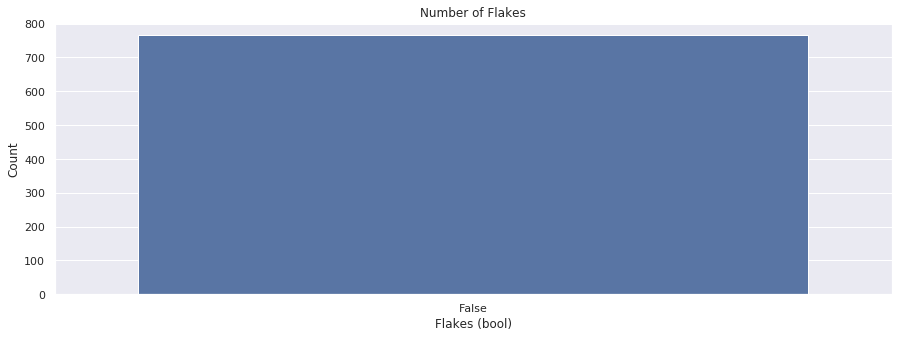

In [65]:
## Count of flakes identified in the tests for a particular grid(job) in a given TestGrid dashboard tab
sns.countplot(x="flake", data=df)
plt.xlabel("Flakes (bool)")
plt.ylabel("Count")
plt.title("Number of Flakes")
plt.show()

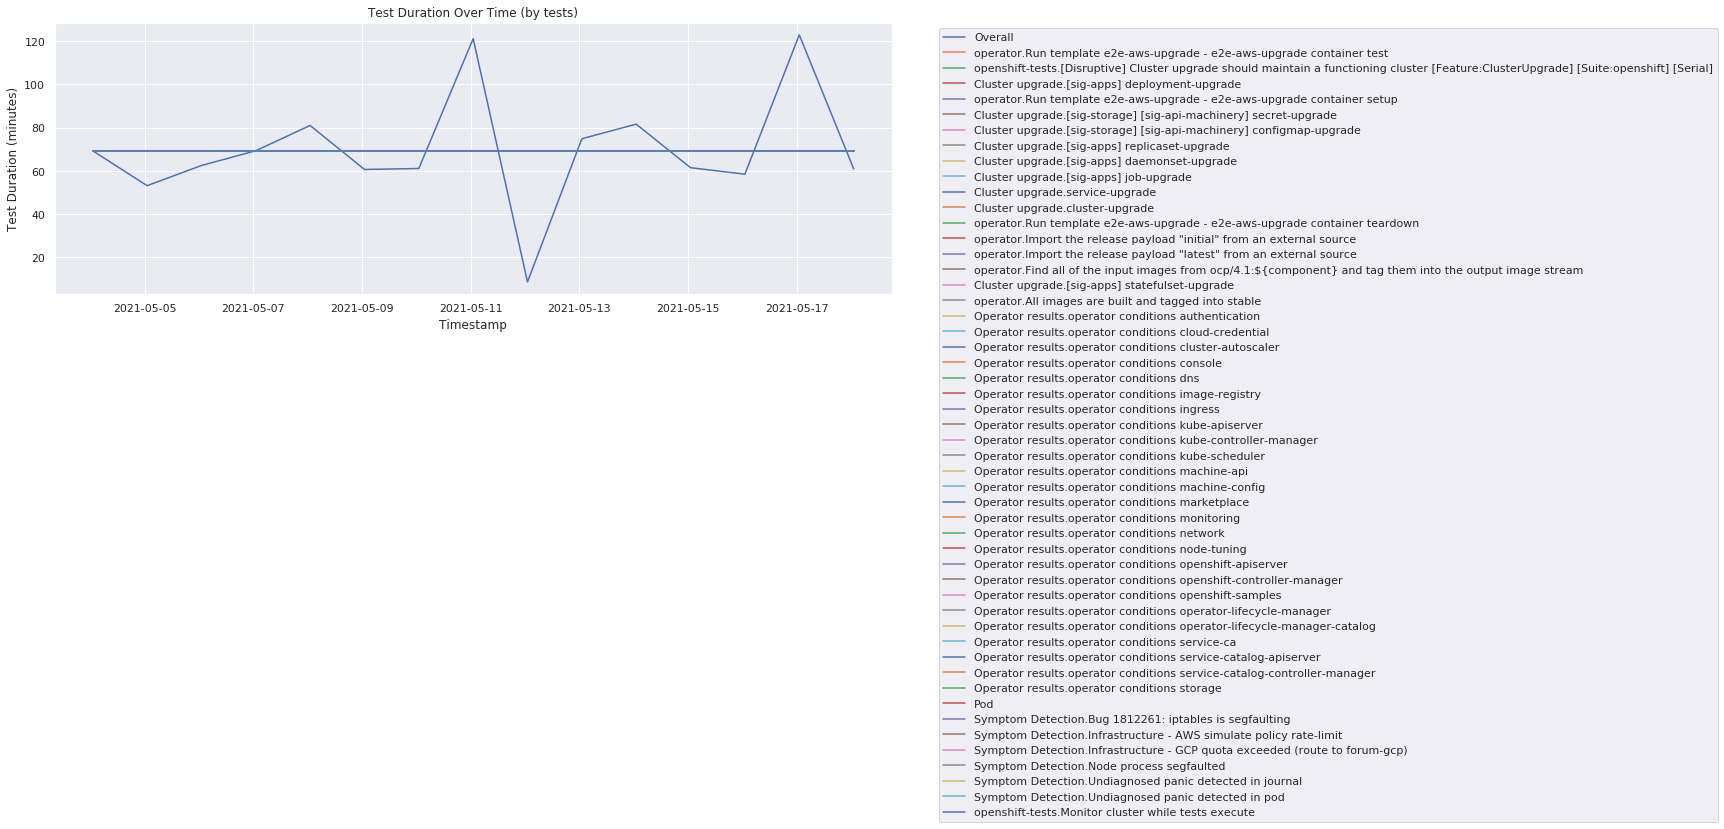

In [66]:
# Here we are plotting the test duration metric over time for different tests within a given dashboard tab
plot_tests(
    selected_tab,
    selected_grid,
    df,
    selected_kpis[0],
    "Timestamp",
    "Test Duration (minutes)",
    "Test Duration Over Time (by tests)",
)

**NOTE** The values for "test_duration" are only available for "Overall" hence the above graph shows only one lineplot with variation and rest all are overlapping at 80.

## Conclusion
In this notebook, we have tried to read the collected metrics from ceph and use visualization libraries like `seaborn` to explore our data. We have tried different granularities here:

* Dashboard, Job pair: Here we visualize all the available KPIs for a selected dashboard, job pair.
* Job level : Here we choose a dashboard and analyze across various jobs for "Overall" test.
* Test level : Here we choose a dashboard and job and then visualize the metrics for various tests.

For future work, we could look into other collected metrics and explore more visualization tools for further detailed analyses. 